<a href="https://colab.research.google.com/github/krzysztof-kar/ML2025/blob/main/Lab02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: EM Clustering in 2D**
-------------------------------

You have seen how the **Expectation-Maximization (EM)** algorithm can fit a Gaussian Mixture Model (GMM) to a 2D dataset. You should now explore:

## **Primary Question**

**How can we visualize the *decision boundary* for attributing a *new* (unlabeled) point to one of the GMM clusters?**  

In other words, given a 2D data distribution modeled by EM, think of a way to clearly show (on a plot) *which* cluster a point would be assigned to (or which cluster has the highest responsibility (posterior probability) for that point)?  

The plot should comprehensively cover the entire visible region, ensuring that for any point on the plot, it is immediately evident which cluster it would belong to. You can plot **lines** separating clusters or use a **color map** showing each point's "most likely cluster".

You can illustrate your approach with **the same** 2D dataset that we used in class, or you can find another suitable 2D dataset, it's up to you. Note however, that having 3 clusters enhances the clarity of the visualization—while 2 clusters result in overly simple boundaries, using 4 or more clusters can make the entire plot difficult to interpret. Try to choose a dataset with 3 clusters.

Discuss any irregularities observed in the resulting plot. If a decision boundary suggests that a region should be attributed to a cluster in a counterintuitive way (we saw it in class!), provide an explanation for why this might occur. It may be also an indication you have a bug in your code.

## **Secondary Question**

**If we *didn't know* the number of clusters in advance, how could we decide on a suitable $K$ for the clustering algorithm?**  

You can illustrate your approach with **the same** dataset as in the primary question by trying different values of $K$ (and optionally plotting the evaluation metric values, e.g. silhouette scores, etc.). Or you can find another suitable dataset, it's up to you. Note, that the dataset doesn't need to be 2D in this task.

## **Task & Deliverables**

1. **Colab Notebook**  
   - Create a **Colab notebook** that:
     - Clearly **answers** both the **primary** and **secondary** questions with appropriate plots and short explanations.
     - Uses Python code (e.g. `scikit-learn` for GMM) to visualize:
       1. The **data** and **cluster assignments**.
       2. The **decision boundary** (lines or a color map) indicating each cluster's region.
       3. A demonstration (chart or table) of how you would pick a suitable number of clusters $K$ when it is not known.
   - Remember to use the `$` symbol to delimit **inline equations** and `$$` to delimit **full-line equations**.

2. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.



# ROZWIĄZANIE:

Korzystając z parametrów dostarczonych przez model dopasowany model, liczę "resposibility" dla punktów siatki pokrywającej obszar, na którym leżą punkty.

Najpierw generuję dane identycznie jak na ćwiczeniach:

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

Podobnie z dopasowaniem modelu i definicją funkcji liczących gęstość i responsibility:


In [76]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import Normalize

def fit_model(model_class, X, **kwargs):
    model = model_class(**kwargs)
    model.fit(X)

    return model

gm_model = fit_model(GaussianMixture, data_X, n_components=3, covariance_type='full', random_state=42)
gm_labels = gm_model.predict(data_X)


def gaussian_pdf(x, mean, cov):

    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)


def resp_grid(grid_x, grid_y, N, pi, mu, Sigma):
    K = len(pi)
    resp = np.zeros((N*N, K))

    for n1 in range(N):
        for n2 in range(N):
          for k in range(K):
            grid_point = np.array([grid_x[n1, n2], grid_y[n1, n2]])
            resp[n1*N+n2, k] = pi[k] * gaussian_pdf(grid_point, mu[k], Sigma[k])
          resp[n1*N+n2, :] /= np.sum(resp[n1*N+n2, :])

    return resp




Wyciągam z modelu wagi, średnie i kowariancje komponentów i liczę responsibility dla punktów siatki, na końcu otrzymuję osobne mapowanie responsibility dla każdego komponentu:

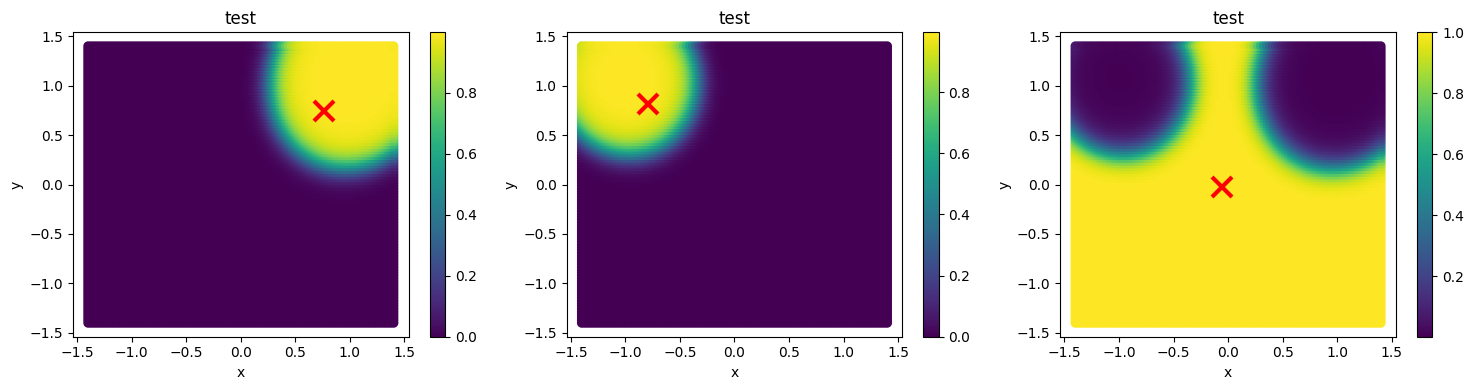

In [77]:

N = 100
linsp = np.linspace(-1.4, 1.4, N)
grid_x, grid_y = np.meshgrid(linsp, linsp)
pi = gm_model.weights_
mu = gm_model.means_
Sigma = gm_model.covariances_
resp = resp_grid(grid_x, grid_y, N, pi, mu, Sigma)

K = 3
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for k in range(K):
      sc = axes[k].scatter(grid_x, grid_y, c=resp[:, k], cmap='viridis')
      axes[k].set_title(f'test')
      axes[k].set_xlabel('x')
      axes[k].set_ylabel('y')
      # Plot for the cluster center: "X" in red
      cp = axes[k].plot(mu[k,0], mu[k,1], 'rx', markersize=14, mew=3)
      # Add a colorbar
      plt.colorbar(sc, ax=axes[k])

plt.tight_layout()
plt.show()

Aby połączyć wszystko w całość, wybieram za pomocą funkcji argmax komponent, dla którego responsibility w danym punkcie jest największe. Ostateczny wykres zgadza się z przypisaniem poprzednich punktów oraz naszymi ogólnymi oczekiwaniami: dwa mniejsze, eliptyczne obszary w "uszach" myszy, pozostałe punkty wpadają do największego komponentu.

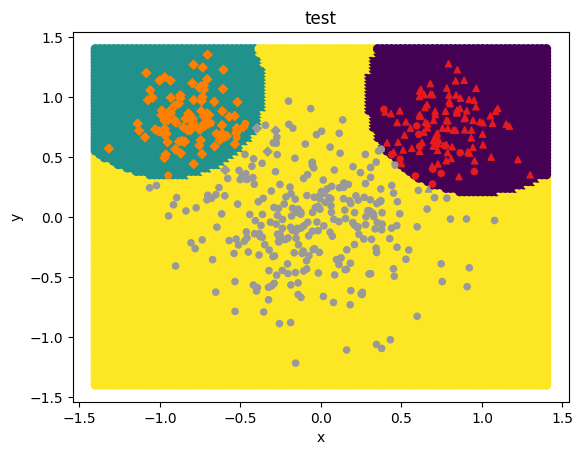

In [78]:
maxresp = np.argmax(resp, axis=1)
fig, axes = plt.subplots()
sc = plt.scatter(grid_x, grid_y, c=maxresp, cmap='viridis')
axes.set_title(f'test')
axes.set_xlabel('x')
axes.set_ylabel('y')


data_counts = [300, 100, 100]
markers = ['o', '^', 'D']

norm = Normalize(vmin=0, vmax=2)

start = 0
# EM (GaussianMixture)
for original_group in range(3):
  end = start + data_counts[original_group]
  axes.scatter(data_X[start:end,0], data_X[start:end,1], c=gm_labels[start:end], marker=markers[original_group], cmap='Set1', s=20, norm=norm)
  start = end

plt.show()

# PYTANIE 2:

Do zadania wybrania optymalnej liczby klastrów można podejść na różne sposoby. Najprostszym z nich jest "metoda łokcia"/elbow method, gdzie szukamy ilości klastów takiej, że przy dalszej jej zwiększaniu ilość wyjaśnianej wariancji rośnie znacznie wolniej. 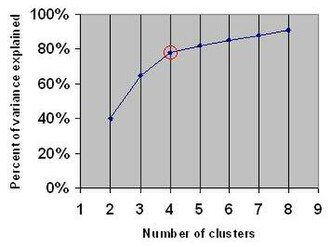

Jest to metoda raczej heurystyczna - nie zawsze taki punkt musi być jasno widoczny.

Możemy też próbować maksymalizować wskaźnik sylwetki dla klastrowania - jeśli dla jakiejś liczby klastrów dane w klastrach będą najbardziej do siebie podobne i najbardziej odległe od pozostałych klastrów to możemy uznać taką liczbę za optymalną.

Wykres dla tej metody:

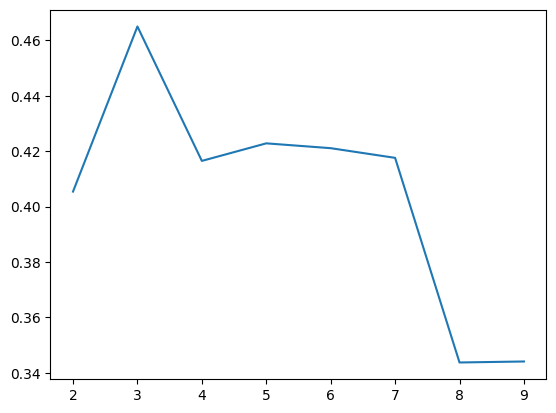

In [80]:
from sklearn.metrics import silhouette_score



K = 10
silh = np.zeros(K)
for k in range(2,K):
        gm_model = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gm_model.fit(data_X)
        silh[k] = silhouette_score(data_X, gm_model.predict(data_X))


plt.plot(range(2,K), silh[2:])





